In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
DATA_DIR = "/kaggle/input/chequedetection"
IMG_DIR = os.path.join(DATA_DIR, "Images")

VALID_EXTS = (".jpg", ".jpeg", ".png")

image_files = [
    f for f in os.listdir(IMG_DIR)
    if f.lower().endswith(VALID_EXTS)
]

print("Total cheque images:", len(image_files))
print("Sample:", image_files[:5])


Total cheque images: 112
Sample: ['Cheque309133.jpg', 'Cheque309137.jpg', 'Cheque309106.jpg', 'Cheque309098.jpg', 'Cheque309121.jpg']


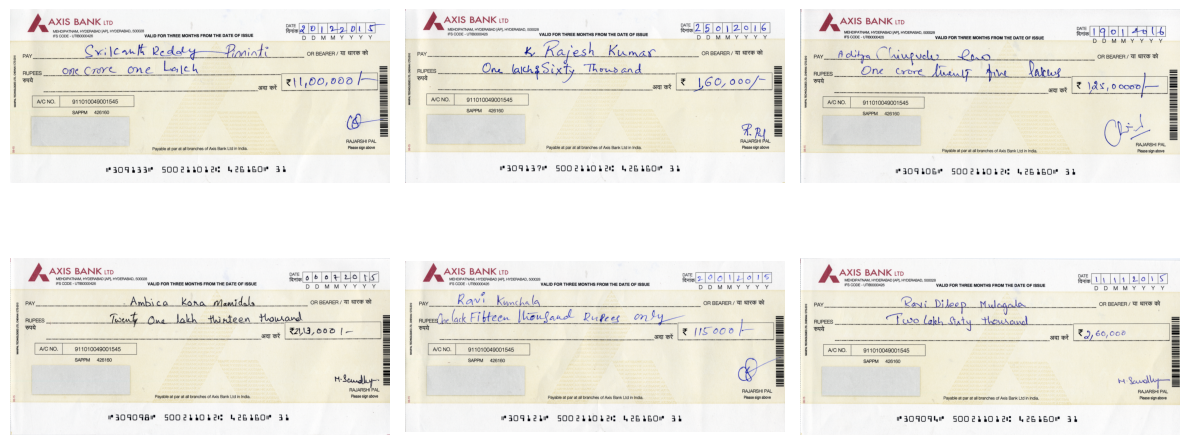

In [3]:
plt.figure(figsize=(12,6))
for i, img_name in enumerate(image_files[:6]):
    img = Image.open(os.path.join(IMG_DIR, img_name)).convert("RGB")
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
def make_fake(image):
    img = np.array(image)

    if np.random.rand() < 0.5:
        img = cv2.GaussianBlur(img, (5,5), 0)

    if np.random.rand() < 0.5:
        noise = np.random.normal(0, 20, img.shape).astype(np.uint8)
        img = cv2.add(img, noise)

    if np.random.rand() < 0.5:
        x = np.random.randint(0, img.shape[1] - 150)
        y = np.random.randint(0, img.shape[0] - 80)
        cv2.rectangle(img, (x,y), (x+150, y+80), (0,0,0), -1)

    return Image.fromarray(img)

In [5]:
class ChequeDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = [
            f for f in os.listdir(image_dir)
            if f.lower().endswith(VALID_EXTS)
        ]

    def __len__(self):
        return len(self.images) * 2

    def __getitem__(self, idx):
        img_name = self.images[idx // 2]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")

        if idx % 2 == 0:
            label = 0  # REAL
        else:
            image = make_fake(image)
            label = 1  # FAKE

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(5),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [7]:
dataset = ChequeDataset(IMG_DIR, transform=train_tfms)

loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0   # IMPORTANT for Kaggle
)

print("Total samples:", len(dataset))

Total samples: 224


In [8]:
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [10]:
EPOCHS = 5
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

Epoch 1/5 - Loss: 0.7602
Epoch 2/5 - Loss: 0.6305
Epoch 3/5 - Loss: 0.4190
Epoch 4/5 - Loss: 0.4029
Epoch 5/5 - Loss: 0.4585


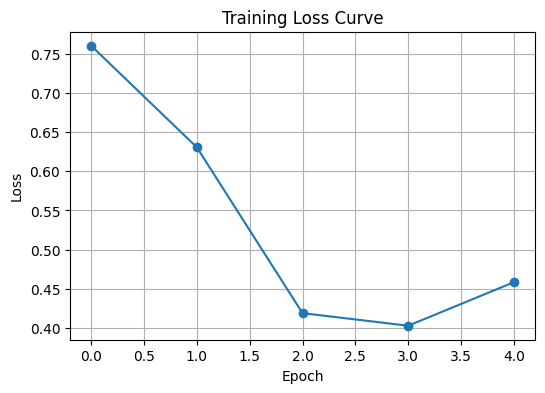

In [11]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, marker="o")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [12]:
torch.save(model.state_dict(), "cheque_global_model.pth")
print("Model saved successfully")


Model saved successfully


In [13]:
def predict_cheque(image_path, model, device):
    model.eval()

    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    label_map = {0: "REAL", 1: "FAKE"}
    return label_map[pred], probs[0][pred].item(), image


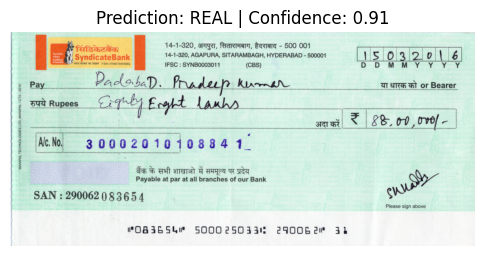

In [14]:
test_image_path = "/kaggle/input/chequedetection/Images/Cheque083654.jpg"

label, confidence, image = predict_cheque(
    test_image_path, model, device
)

plt.figure(figsize=(6,4))
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {label} | Confidence: {confidence:.2f}")
plt.show()

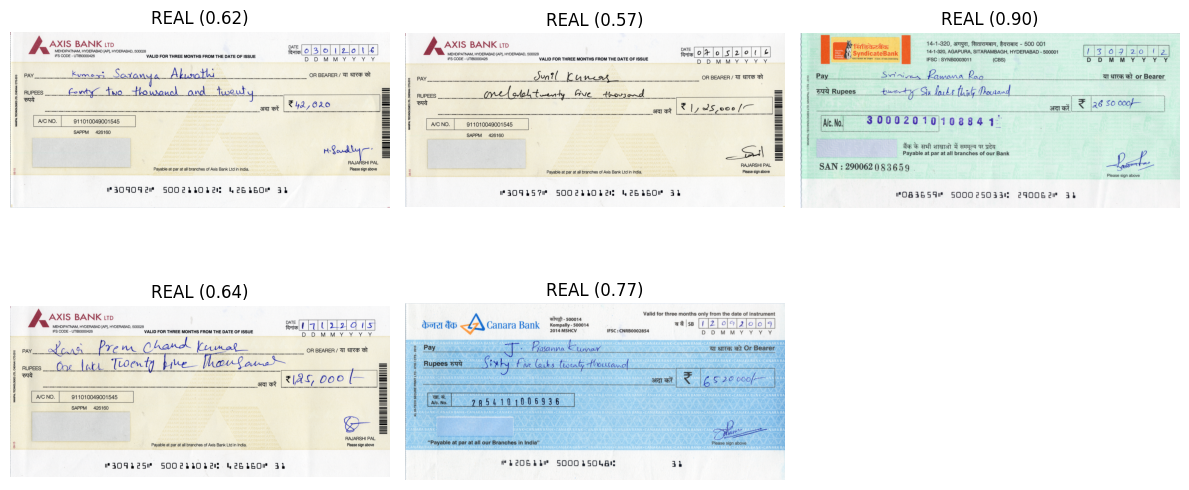

In [15]:
samples = random.sample(image_files, 5)

plt.figure(figsize=(12,6))
for i, img_name in enumerate(samples):
    path = os.path.join(IMG_DIR, img_name)
    label, conf, img = predict_cheque(path, model, device)

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"{label} ({conf:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()


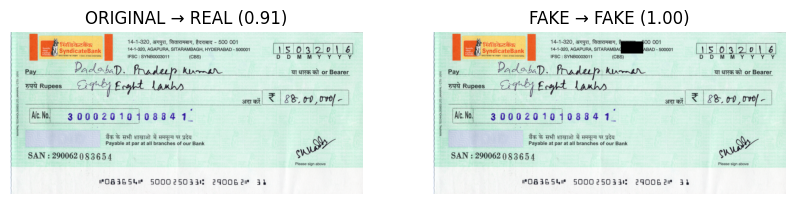

In [16]:
# Test real vs fake side-by-side
orig_path = "/kaggle/input/chequedetection/Images/Cheque083654.jpg"

orig_label, orig_conf, orig_img = predict_cheque(orig_path, model, device)
fake_img = make_fake(orig_img)
fake_tensor = train_tfms(fake_img).unsqueeze(0).to(device)

with torch.no_grad():
    out = model(fake_tensor)
    probs = torch.softmax(out, dim=1)
    fake_label = "FAKE" if torch.argmax(probs)==1 else "REAL"
    fake_conf = probs[0][torch.argmax(probs)].item()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(orig_img)
plt.title(f"ORIGINAL → {orig_label} ({orig_conf:.2f})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(fake_img)
plt.title(f"FAKE → {fake_label} ({fake_conf:.2f})")
plt.axis("off")

plt.show()